In [1]:
import os
import numpy as np
from keras.datasets import imdb
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
max_features = 10000 #max words
maxlen = 20 #maximum length in sequence we want to pass to embedding layer
dimensionality = 8

(x_train, y_train), (x_test,y_test) = imdb.load_data( num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Training without taking in account relationships between words

In [3]:
model = Sequential()
model.add(Embedding(max_features, dimensionality, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10


/Users/gursharan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


20000/20000 [==============================] - 0s 22us/step - loss: 0.6838 - acc: 0.5857 - val_loss: 0.6632 - val_acc: 0.6620
Epoch 2/10
20000/20000 [==============================] - 0s 16us/step - loss: 0.6033 - acc: 0.7273 - val_loss: 0.5714 - val_acc: 0.7180
Epoch 3/10
20000/20000 [==============================] - 0s 18us/step - loss: 0.5061 - acc: 0.7710 - val_loss: 0.5200 - val_acc: 0.7366
Epoch 4/10
20000/20000 [==============================] - 0s 16us/step - loss: 0.4497 - acc: 0.8001 - val_loss: 0.4995 - val_acc: 0.7498
Epoch 5/10
20000/20000 [==============================] - 0s 17us/step - loss: 0.4152 - acc: 0.8176 - val_loss: 0.4907 - val_acc: 0.7526
Epoch 6/10
20000/20000 [==============================] - 0s 18us/step - loss: 0.3896 - acc: 0.8303 - val_loss: 0.4892 - val_acc: 0.7514
Epoch 7/10
20000/20000 [==============================] - 0s 19us/step - loss: 0.3683 - acc: 0.8421 - val_loss: 0.4907 - val_acc: 0.7560
Epoch 8/10
20000/20000 [============================

### Using pretrained word embeddings!

In [4]:
imdb_dir = '/Users/gursharan/Desktop/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
maxlen = 100
training_samples = 200 #why only 200 samples? pretraining word embeddings are useful when training data is little
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [7]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [8]:
glove_dir = '/Users/gursharan/Desktop/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coef = np.asarray(values[1:], dtype='float32')
    embeddings_index[ word ] = coef
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [10]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#set weights for the embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 1ms/step - loss: 3.6389 - acc: 0.4800 - val_loss: 1.1967 - val_acc: 0.5025
Epoch 2/10
200/200 [==============================] - 0s 750us

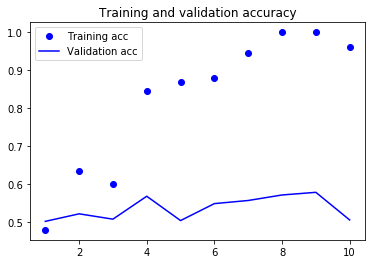

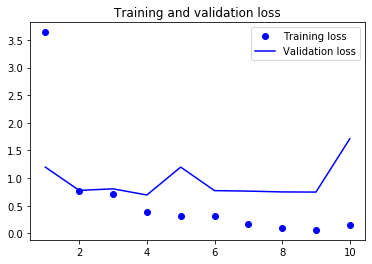

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


/Users/gursharan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6847 - acc: 0.5450 - val_loss: 0.6941 - val_acc: 0.5137
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4784 - acc: 0.9700 - val_loss: 0.7104 - val_acc: 0.5155
Epoch 3/10
200/200 [==============================] - 0s 1ms/step - loss: 0.2699 - acc: 0.9750 - val_loss: 0.7401 - val_acc: 0.5164
Epoch 4/10
200/200 [==============================] - 0s 1ms/step - loss: 0.1215 - acc: 0.9900 - val_loss: 0.6972 - val_acc: 0.5292
Epoch 5/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0553 - acc: 1.0000 - val_loss: 0.7009 - val_acc: 0.5241
Epoch 6/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0298 - acc: 1.0000 - val_loss: 0.7302 - val_acc: 0.5224
Epoch 7/10
200/200 [==============================] - 0s 1ms/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.7472 - val_acc: 0.5235
Epoch 8/10
200/200 [========

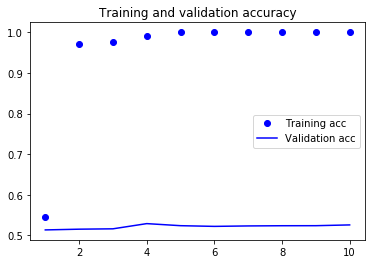

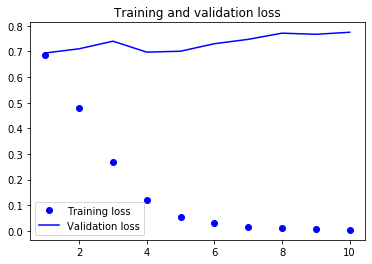

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [15]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 0s 16us/step


[1.7352791878390312, 0.5046399831771851]